In [1]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Any, Tuple
import pickle
import torch
from utilsHannes import mean_pointwise_l2_distance


/opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# ## Functions

# def get_sorted_most_likely_trajectories(logits: np.ndarray, lattice: np.ndarray): # -> Tuple[np.ndarray, np.ndarray]:
    
#     softmax = torch.nn.Softmax(dim=1)
#     probabilities = softmax(torch.Tensor(logits))
#     sortedProbabilitiesIndices = np.flip(np.array(np.argsort(probabilities, axis=-1)), axis=-1).copy()
#     sortedProbabilities = np.array(np.take_along_axis(probabilities, sortedProbabilitiesIndices, axis=-1))
#     sortedTrajectories = lattice[sortedProbabilitiesIndices]
    
#     return sortedProbabilities, sortedTrajectories


# def get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_trajectories, k_nr_of_trajectories, train_boolean): # -> Tuple[np.array, np.array]:
    
#     top_k_trajectories = sorted_predicted_trajectories[:,:k_nr_of_trajectories,:,:]
    
#     n_epochs = num_epochs # TODO, automate
#     if train_boolean == 'yes':
#         n_datapoints_per_epoch = 2048 # TODO, automate
#     else:
#         n_datapoints_per_epoch = 512 # TODO, automate
    
#     ave_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
#     min_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
#     count = 0
#     # Loop over epochs
#     for e in range(n_epochs):
        
#         # Loop over datapoints
#         for d in range(n_datapoints_per_epoch):
#             tmp_ADE = 1e10
#             min_ADE[d,e] = tmp_ADE
#             # Loop over each trajectory
#             for k in range(k_nr_of_trajectories):
#                 tmp_ADE = np.mean(np.linalg.norm(top_k_trajectories[count,k,:,:] - ground_truth_trajectories[count,:,:], axis=-1))
#                 ave_ADE[d,e] += tmp_ADE/k_nr_of_trajectories
#                 if tmp_ADE < min_ADE[d,e]:
#                     min_ADE[d,e] = tmp_ADE
#             count += 1
            
#     return np.mean(min_ADE, axis=0), np.mean(ave_ADE, axis=0)



In [3]:
## Load data

# epochs = [50,51,52,53,54,55,56,57]
# legend_list = ['250*250','125*125','50*50','10*10','2*2','1*1','50*50 + covernet input','125*125 + covernet input']

# epochs = [299,301]
# legend_list = ['10*10 (299e)','500*500 (301e)']
# num_epochs = min(epochs)

# epochs = [499]
# legend_list = ['125*125 (569e)']
# num_epochs = 569



# With training results
epochs = [500] #501
legend_list = ['10*10 (570e), eps=8']#'250*250 (501e), eps=8'

# epochs = [502] # 502
# legend_list = ['250*250 (502e), eps=2']

# epochs = [503]
# legend_list = ['10*10 (167e), eps=2']

# epochs = [504]
# legend_list = ['10*10 (e), eps=4']

epochs = [500, 504, 503]
legend_list = ['10*10 (570e), eps=8','10*10 (e), eps=4', '10*10 (167e), eps=2']


num_epochs = 160

# Files
file_path_list = [f"tmpResults/results_epochs={epoch}" for epoch in epochs]
num_files = len(file_path_list)

# Settings
file_number = 0
train_boolean = 'no'

# Load the .npy files
if train_boolean == 'yes':
    logits_loaded_list = [(np.load(f'{file_path}_train_logits.npy'))[:num_epochs*2048] for file_path in file_path_list]
    ground_truth_loaded_list = [(np.load(f'{file_path}_train_ground_truth.npy'))[:num_epochs*2048] for file_path in file_path_list]
elif train_boolean == 'no':
    logits_loaded_list = [(np.load(f'{file_path}_val_logits.npy'))[:num_epochs*512] for file_path in file_path_list]
    ground_truth_loaded_list = [(np.load(f'{file_path}_val_ground_truth.npy'))[:num_epochs*512] for file_path in file_path_list]
else:
    logits_loaded_list = [(np.load(f'{file_path}_logits.npy'))[:num_epochs*512] for file_path in file_path_list]
    ground_truth_loaded_list = [(np.load(f'{file_path}_ground_truth.npy'))[:num_epochs*512] for file_path in file_path_list]
    
softmaxy = torch.nn.Softmax(dim=1)
probabilities_list = [softmaxy(torch.Tensor(logits)).detach().numpy().squeeze() for logits in logits_loaded_list]


# Print the data
print(f"len(logits_loaded_list) = {len(logits_loaded_list)}")
print(f"len(ground_truth_loaded_list) = {len(ground_truth_loaded_list)}")
print(f"logits_loaded_list[{file_number}].shape = {logits_loaded_list[file_number].shape}")
print(f"probabilities_list[{file_number}].shape = {probabilities_list[file_number].shape}")
print(f"ground_truth_loaded_list[{file_number}].shape = {ground_truth_loaded_list[file_number].shape}")

# Load lattice
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    trajectories = pickle.load(f)
lattice8 = np.array(trajectories)
              
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_4.pkl', 'rb') as f:
    trajectories = pickle.load(f)
lattice4 = np.array(trajectories)
    
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_2.pkl', 'rb') as f:
    trajectories = pickle.load(f)
lattice2 = np.array(trajectories)
    
lattice_list = [lattice8, lattice4, lattice2]

len(logits_loaded_list) = 3
len(ground_truth_loaded_list) = 3
logits_loaded_list[0].shape = (81920, 64)
probabilities_list[0].shape = (81920, 64)
ground_truth_loaded_list[0].shape = (81920, 12, 2)


In [4]:
## Functions

def get_sorted_most_likely_trajectories(logits: np.ndarray, lattice: np.ndarray): # -> Tuple[np.ndarray, np.ndarray]:
    
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(torch.Tensor(logits))
    sortedProbabilitiesIndices = np.flip(np.array(np.argsort(probabilities, axis=-1)), axis=-1).copy()
    sortedProbabilities = np.array(np.take_along_axis(probabilities, sortedProbabilitiesIndices, axis=-1))
    sortedTrajectories = lattice[sortedProbabilitiesIndices]
    
    return sortedProbabilities, sortedTrajectories


def get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_trajectories, k_nr_of_trajectories, train_boolean): # -> Tuple[np.array, np.array]:
    
    top_k_trajectories = sorted_predicted_trajectories[:,:k_nr_of_trajectories,:,:]
    
    n_epochs = num_epochs # TODO, automate
    if train_boolean == 'yes':
        n_datapoints_per_epoch = 2048 # TODO, automate
    else:
        n_datapoints_per_epoch = 512 # TODO, automate
    
    ave_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    min_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    count = 0
    # Loop over epochs
    for e in range(n_epochs):
        
        # Loop over datapoints
        for d in range(n_datapoints_per_epoch):
            tmp_ADE = 1e10
            min_ADE[d,e] = tmp_ADE
            # Loop over each trajectory
            for k in range(k_nr_of_trajectories):
                tmp_ADE = np.mean(np.linalg.norm(top_k_trajectories[count,k,:,:] - ground_truth_trajectories[count,:,:], axis=-1))
                ave_ADE[d,e] += tmp_ADE/k_nr_of_trajectories
                if tmp_ADE < min_ADE[d,e]:
                    min_ADE[d,e] = tmp_ADE
            count += 1
            
    return np.mean(min_ADE, axis=0), np.mean(ave_ADE, axis=0)


len(sorted_predicted_probabilities_list) = 3
len(sorted_predicted_trajectories_list) = 3
sorted_predicted_probabilities_list[0].shape = (81920, 64)
sorted_predicted_trajectories_list[0].shape = (81920, 64, 12, 2)

min_ADE_list[0].shape = (160,)

ave_ADE_list[0].shape = (160,)

min_ADE_list[0][-1] = 2.7425586048045605

ave_ADE_list[0][-1] = 7.179143301487606


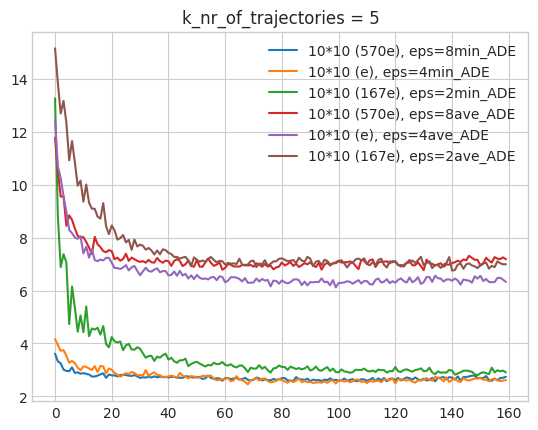

In [5]:
############### Calculate and plot many files

k_nr_of_trajectories = 5

results1 = [get_sorted_most_likely_trajectories(logits_loaded, lattice) for logits_loaded, lattice in zip(logits_loaded_list, lattice_list)]
sorted_predicted_probabilities_list, sorted_predicted_trajectories_list = zip(*results1)

results2 = [get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded, k_nr_of_trajectories, train_boolean) for sorted_predicted_trajectories, ground_truth_loaded in zip(sorted_predicted_trajectories_list, ground_truth_loaded_list)]
min_ADE_list, ave_ADE_list = zip(*results2)

print(f"len(sorted_predicted_probabilities_list) = {len(sorted_predicted_probabilities_list)}")
print(f"len(sorted_predicted_trajectories_list) = {len(sorted_predicted_trajectories_list)}")
print(f"sorted_predicted_probabilities_list[{file_number}].shape = {sorted_predicted_probabilities_list[file_number].shape}")
print(f"sorted_predicted_trajectories_list[{file_number}].shape = {sorted_predicted_trajectories_list[file_number].shape}")
# print(f"sortedTrajectories = {sorted_predicted_trajectories_list[0][2]}") # [0][0/1] and [0][2/3] the same

print(f"\nmin_ADE_list[{file_number}].shape = {min_ADE_list[file_number].shape}")
print(f"\nave_ADE_list[{file_number}].shape = {ave_ADE_list[file_number].shape}")
print(f"\nmin_ADE_list[{file_number}][-1] = {min_ADE_list[file_number][-1]}")
print(f"\nave_ADE_list[{file_number}][-1] = {ave_ADE_list[file_number][-1]}")


## Plot ADE
[plt.plot(min_ADE, label=legend+', min_ADE') for min_ADE, legend in zip(min_ADE_list, legend_list)]
[plt.plot(ave_ADE, label=legend+', ave_ADE') for ave_ADE, legend in zip(ave_ADE_list, legend_list)]
plt.legend();
plt.title(f"k_nr_of_trajectories = {k_nr_of_trajectories}");



sorted_predicted_probabilities.shape = (81920, 64)
sorted_predicted_trajectories.shape = (81920, 64, 12, 2)

min_ADE.shape = (160,)

ave_ADE.shape = (160,)

min_ADE[-1] = 5.788496650977908

ave_ADE[-1] = 5.788496650977908


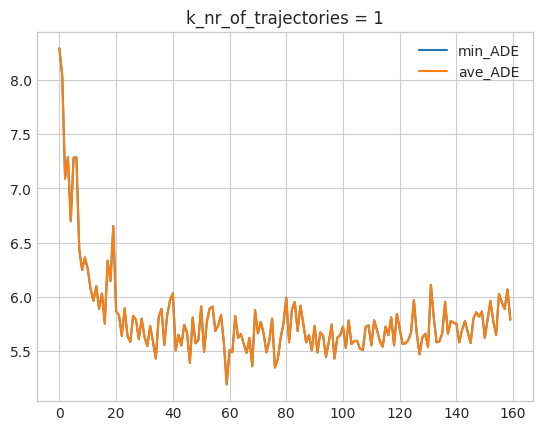

In [7]:
############## Calculate and plot one files

k_nr_of_trajectories = 1

sorted_predicted_probabilities, sorted_predicted_trajectories = get_sorted_most_likely_trajectories(logits_loaded_list[file_number], lattice_list[file_number])
min_ADE, ave_ADE = get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded_list[file_number], k_nr_of_trajectories, train_boolean)

print(f"sorted_predicted_probabilities.shape = {sorted_predicted_probabilities.shape}")
print(f"sorted_predicted_trajectories.shape = {sorted_predicted_trajectories.shape}")
print(f"\nmin_ADE.shape = {min_ADE.shape}")
print(f"\nave_ADE.shape = {ave_ADE.shape}")
print(f"\nmin_ADE[-1] = {min_ADE[-1]}")
print(f"\nave_ADE[-1] = {ave_ADE[-1]}")

### One file ###
plt.plot(min_ADE, label="min_ADE")
plt.plot(ave_ADE, label="ave_ADE")
plt.legend();
plt.title(f"k_nr_of_trajectories = {k_nr_of_trajectories}");


predicted = 2
closest_lattice_index = 3
correct = False


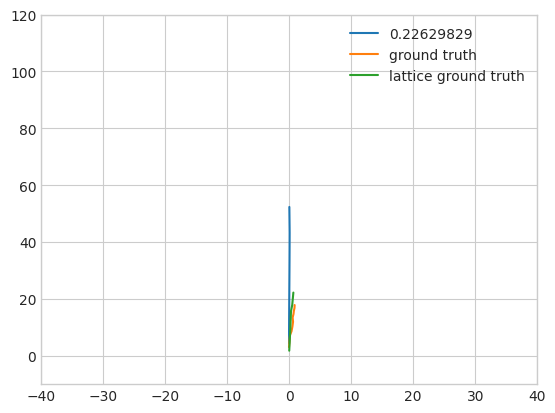

In [9]:
## Plot prediction vs ground truth
epoch = 50
index = 9
if train_boolean == 'yes':
    test_index = epoch*2048 + index
else: 
    test_index = epoch*512 + index
    
nrOfTopTrajectories = 1
ground_truth_trajectory = ground_truth_loaded_list[file_number][test_index]
probabilities = probabilities_list[file_number][test_index]
closest_lattice_index = mean_pointwise_l2_distance(torch.Tensor(lattice_list[file_number]), torch.Tensor(ground_truth_trajectory))
topProbabilitiesIndices = np.argsort(probabilities)[::-1][0:nrOfTopTrajectories]
topProbabilities = [probabilities[index] for index in topProbabilitiesIndices]

# Lattice ground truth
predicted = topProbabilitiesIndices[0]
print(f"predicted = {predicted}")
print(f"closest_lattice_index = {closest_lattice_index}")
correct = (predicted == closest_lattice_index)
print(f"correct = {correct}")

# Plot predictions
[plt.plot(lattice_list[file_number][mode,:,0],lattice_list[file_number][mode,:,1], label=topProbabilities[i]) for i, mode in enumerate(topProbabilitiesIndices)]
# Plot ground truth
plt.plot(ground_truth_trajectory[:,0], ground_truth_trajectory[:,1], label="ground truth")
# Plot lattice ground truth
plt.plot(lattice_list[file_number][closest_lattice_index,:,0],lattice_list[file_number][closest_lattice_index,:,1], label="lattice ground truth")
plt.ylim([-10,120]); plt.xlim([-40,40]); plt.legend(); plt.show()

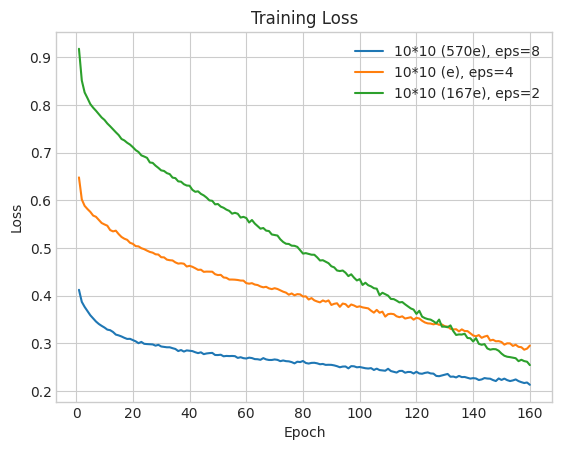

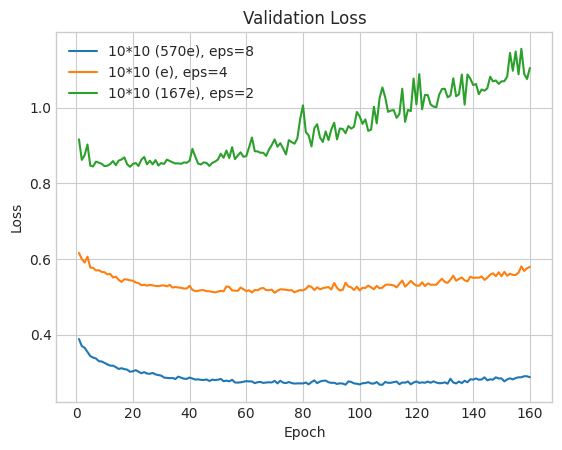

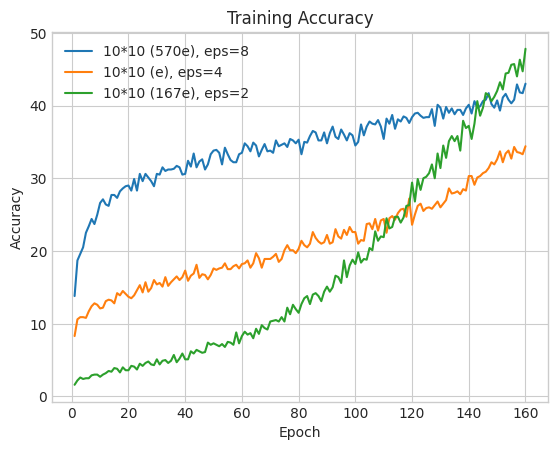

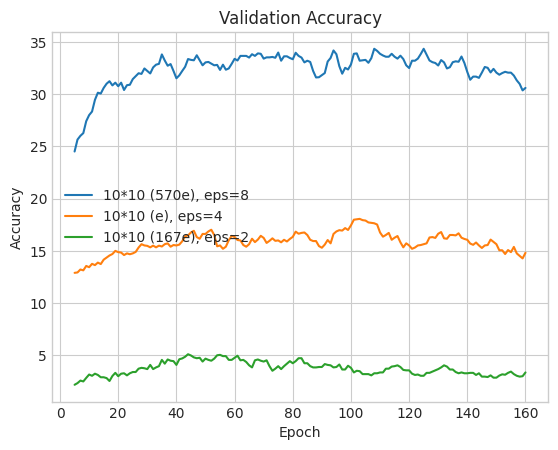

In [10]:
## Plot loss and accuracy

# File names
loss_acc_file_names = [f"{file_path}_loss_and_acc.txt" for file_path in file_path_list]

# Create empty arrays to store the data from text files
epochs = np.zeros((num_files, num_epochs))
train_loss = np.zeros((num_files, num_epochs))
val_loss = np.zeros((num_files, num_epochs))
train_acc = np.zeros((num_files, num_epochs))
val_acc = np.zeros((num_files, num_epochs))

# Loop over the text files
for i, filename in enumerate(loss_acc_file_names):
    with open(filename, 'r') as f:
        for j, line in enumerate(f):
            if j == num_epochs:
                break
            if line.startswith('Epoch'):
                parts = line.split(': ')
                epoch = int(parts[0].split('[')[1].split('/')[0])
                epochs[i][j] = epoch
                train_loss[i][j] = float(parts[2].split(' |')[0])
                val_loss[i][j] = float(parts[3].split(' |')[0])
                train_acc[i][j] = float(parts[4].split(' %')[0])
                val_acc[i][j] = float(parts[5].split(' %')[0])
if num_files > 4:
    val_loss[4,0] = val_loss[4,1]



# Training loss
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], train_loss[i], label=f'File {i+1}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend_list)
plt.show()

# Validation loss
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], val_loss[i], label=f'File {i+1}')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend_list)
plt.show()

# Training accuracy
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], train_acc[i], label=f'File {i+1}')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(legend_list)
plt.show()

# Validation accuracy
plt.figure()
for i in range(num_files):
    # Convert the list to a pandas DataFrame
    df = pd.DataFrame(val_acc[i])
    # Apply a rolling window of size x and take the mean of each window
    smoothed = df.rolling(5).mean()
    # Convert the smoothed DataFrame back to a list
    smoothed_list = smoothed.values.tolist()
    numpy_smoothed_list = np.array(smoothed_list)
    squeezed_numpy_smoothed_list = np.squeeze(numpy_smoothed_list, 1)
    plt.plot(epochs[i], squeezed_numpy_smoothed_list, label=f'File {i+1}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(legend_list)
plt.show()


(array([39., 45., 56., 39., 27.,  8.,  5.,  4.,  2.,  3., 33.,  3., 18.,
         5.,  2.,  1.,  0., 30.,  1.,  8.,  1.,  2., 13.,  0.,  1.,  3.,
         0.,  0.,  7., 10.,  2.,  0.,  0.,  4.,  0.,  0.,  4.,  4.,  5.,
         4.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  6.,  0.,  0.,  0.,
         2.,  0.,  1.,  2.,  1.,  2., 71., 24.,  0.,  1.,  2.,  8.]),
 array([ 0.     ,  0.96875,  1.9375 ,  2.90625,  3.875  ,  4.84375,
         5.8125 ,  6.78125,  7.75   ,  8.71875,  9.6875 , 10.65625,
        11.625  , 12.59375, 13.5625 , 14.53125, 15.5    , 16.46875,
        17.4375 , 18.40625, 19.375  , 20.34375, 21.3125 , 22.28125,
        23.25   , 24.21875, 25.1875 , 26.15625, 27.125  , 28.09375,
        29.0625 , 30.03125, 31.     , 31.96875, 32.9375 , 33.90625,
        34.875  , 35.84375, 36.8125 , 37.78125, 38.75   , 39.71875,
        40.6875 , 41.65625, 42.625  , 43.59375, 44.5625 , 45.53125,
        46.5    , 47.46875, 48.4375 , 49.40625, 50.375  , 51.34375,
        52.3125 , 53.28125

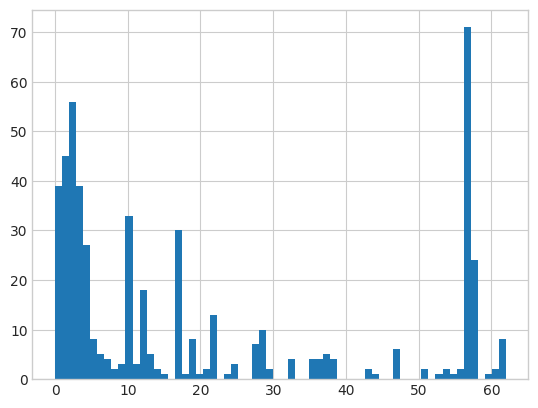

In [11]:
# Histogram of grount truth trajectories

if train_boolean == 'yes':
    nr_datapoints = 2048
else: 
    nr_datapoints = 512
    
closest_lattice_index = [mean_pointwise_l2_distance(torch.Tensor(lattice_list[file_number]), torch.Tensor(ground_truth_trajectory)) for ground_truth_trajectory in ground_truth_loaded_list[file_number][:nr_datapoints]]

plt.hist(closest_lattice_index, bins = 64)
